In [13]:
import datetime
import warnings
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

from src.datasource.yahoodata import YahooDataSource
from src.backtest.backtest import BackTest
from src.scenario import CopulaGen, PastGen

warnings.filterwarnings("ignore")

tickers = ['MSFT','MMM', 'AXP', 'AMGN', 'AAPL', 'CSCO','IBM','NVDA','TSLA','AMZN','MRK']
#tickers = ["RELIANCE.NS","MRF.NS","ICICIBANK.NS","INFY.NS","HINDUNILVR.NS","BHARTIARTL.NS","KOTAKBANK.NS","LT.NS","TCS.NS","BHARTIARTL.NS","TECHM.NS","NTPC.NS"]
# tickers = ["AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA"]
column_name = 'Close'

# results
results = pd.DataFrame()
portfolio_returns = pd.DataFrame()

# date range
start_date = datetime.datetime(2019,1,1)
end_date = datetime.datetime(2022,12,31)
interval = '1d'

# test data fetching
main_data = YahooDataSource(tickers,start_date,end_date,columns=[column_name],interval=interval)
data = main_data.get_data()
main_data.get_data_by_frequency(start_date,end_date,'1d').ffill()

Adding MSFT to the data source
Getting data for MSFT
Adding MMM to the data source
Getting data for MMM
Adding AXP to the data source
Getting data for AXP
Adding AMGN to the data source
Getting data for AMGN
Adding AAPL to the data source
Getting data for AAPL
Adding CSCO to the data source
Getting data for CSCO
Adding IBM to the data source
Getting data for IBM
Adding NVDA to the data source
Getting data for NVDA
Adding TSLA to the data source
Getting data for TSLA
Adding AMZN to the data source
Getting data for AMZN
Adding MRK to the data source
Getting data for MRK


,MSFT,MMM,AXP,AMGN,AAPL,CSCO,IBM,NVDA,TSLA,AMZN,MRK
Date,,,,,,,,,,,
2019-01-03,91.988022,122.083626,86.313255,158.693985,33.952541,34.443115,82.271858,3.173996,20.024000,75.014000,59.012646
2019-01-04,96.266304,127.106232,90.202583,164.118744,35.401951,35.994606,85.485229,3.377346,21.179333,78.769501,60.790028
2019-01-05,96.266304,127.106232,90.202583,164.118744,35.401951,35.994606,85.485229,3.377346,21.179333,78.769501,60.790028
2019-01-06,96.266304,127.106232,90.202583,164.118744,35.401951,35.994606,85.485229,3.377346,21.179333,78.769501,60.790028
2019-01-07,96.389084,126.813919,90.692184,166.327255,35.323162,36.237808,86.090004,3.556145,22.330667,81.475502,60.120525
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,235.345551,92.038414,143.163086,249.577682,130.487778,44.615627,131.266052,15.194948,123.150002,85.250000,105.924110
2022-12-27,233.600677,92.099701,142.549606,249.076447,128.676849,44.662613,131.979630,14.110737,109.099998,83.040001,106.170319
2022-12-28,231.205109,90.621140,140.232040,247.213531,124.728378,44.230362,129.755554,14.025799,112.709999,81.820000,105.185493


In [14]:
from src.algorithms.strategy import EqualyWeighted

# Mean Semi Deviation strategy
equal_weighted = EqualyWeighted()
equal_weighted_bt = BackTest(main_data, equal_weighted)

# with past data
past_gen = PastGen(use_log_returns=False)
equal_weighted_bt.backtest(start_date, end_date, 12,1, '1MS', past_gen)
portfolio_returns["Equaly Weighted"] = equal_weighted_bt.portfolio_value
mean_semi_summary = equal_weighted_bt.get_summary()
results["Equaly Weighted"] = pd.Series(mean_semi_summary)

Adding ^GSPC to the data source
Getting data for ^GSPC


Adding ^GSPC to the data source
Getting data for ^GSPC
Adding ^GSPC to the data source
Getting data for ^GSPC
Adding ^GSPC to the data source
Getting data for ^GSPC


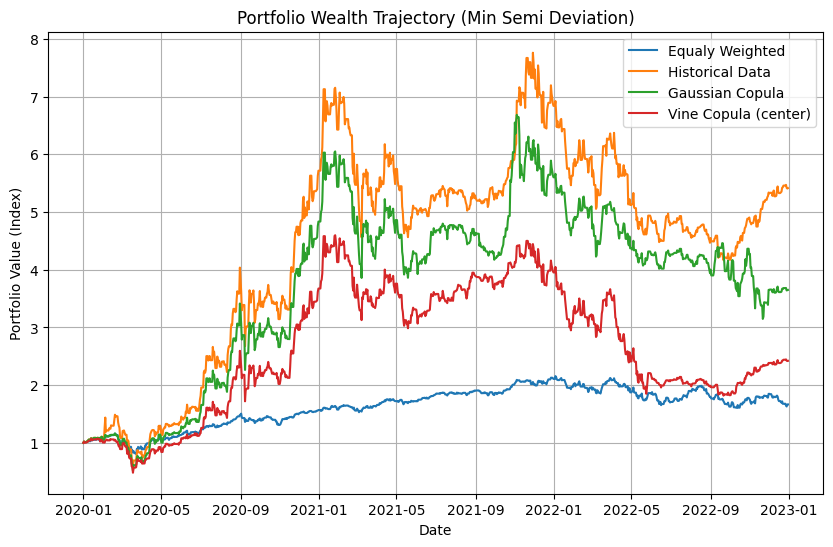

,Equaly Weighted,Historical Data,Gaussian Copula,Vine Copula (center)
Total Return,0.665220,4.413429,2.648979,1.420102
Mean Daily Return,0.000571,0.002068,0.001689,0.001273
Std Dev of Daily Return,0.014436,0.032411,0.031829,0.030451
Sharpe Ratio,0.039545,0.063804,0.053074,0.041798
Max Drawdown,-0.306158,-0.606265,-0.555340,-0.604617
Calmar Ratio,2.172796,7.279698,4.770015,2.348763
Alpha,0.000315,0.001765,0.001373,0.000958
Beta,1.034484,1.224869,1.280682,1.273975


In [15]:
from src.algorithms.strategy import MeanSemidevOpt

# Mean Semi Deviation strategy
meanSemidevOpt = MeanSemidevOpt(0.7)
meanSemidevOpt_bt = BackTest(main_data, meanSemidevOpt)

# with past data
past_gen = PastGen(use_log_returns=False)
meanSemidevOpt_bt.backtest(start_date, end_date, 12,1, '1MS', past_gen)
portfolio_returns["Historical Data"] = meanSemidevOpt_bt.portfolio_value
mean_semi_summary = meanSemidevOpt_bt.get_summary()
results["Historical Data"] = pd.Series(mean_semi_summary)

# with generated data from copula
gaussian_copula_gen = CopulaGen(copula_type='gaussian', sample_size = 100, use_log_returns=False)
meanSemidevOpt_bt.backtest(start_date, end_date, 12,1, '1MS', gaussian_copula_gen)
portfolio_returns["Gaussian Copula"] = meanSemidevOpt_bt.portfolio_value
mean_semi_summary = meanSemidevOpt_bt.get_summary()
results["Gaussian Copula"] = pd.Series(mean_semi_summary)

vine_copula_gen = CopulaGen(copula_type='vine-center', sample_size = 100, use_log_returns=False)
meanSemidevOpt_bt.backtest(start_date, end_date, 12,1, '1MS', vine_copula_gen)
portfolio_returns["Vine Copula (center)"] = meanSemidevOpt_bt.portfolio_value
mean_semi_summary = meanSemidevOpt_bt.get_summary()
results["Vine Copula (center)"] = pd.Series(mean_semi_summary)

# plot portfolio_returns with benchmark
plt.figure(figsize=(10, 6))
for label, values in portfolio_returns.items():
    plt.plot(values, label=label)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Index)')
plt.title('Portfolio Wealth Trajectory (Min Semi Deviation)')
plt.legend()
plt.grid()
plt.show()

display(results)

Adding ^GSPC to the data source
Getting data for ^GSPC
Adding ^GSPC to the data source
Getting data for ^GSPC
Adding ^GSPC to the data source
Getting data for ^GSPC


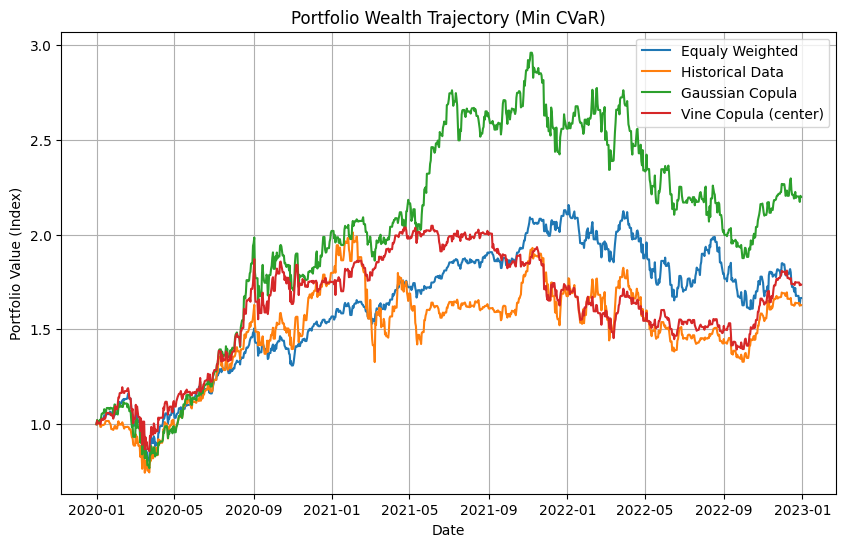

,Equaly Weighted,Historical Data,Gaussian Copula,Vine Copula (center)
Total Return,0.665220,0.628087,1.198986,0.735909
Mean Daily Return,0.000571,0.000656,0.000903,0.000646
Std Dev of Daily Return,0.014436,0.020560,0.019058,0.016834
Sharpe Ratio,0.039545,0.031928,0.047362,0.038399
Max Drawdown,-0.306158,-0.339973,-0.366032,-0.319061
Calmar Ratio,2.172796,1.847459,3.275634,2.306481
Alpha,0.000315,0.000381,0.000635,0.000405
Beta,1.034484,1.116836,1.082807,0.976606


In [16]:
from src.algorithms.strategy import CvarMretOpt

# Min CVaR strategy
cvarmretOpt = CvarMretOpt(0.5,0.05)
cvarmretOpt_bt = BackTest(main_data, cvarmretOpt)

# with past data
past_gen = PastGen(use_log_returns=False)
cvarmretOpt_bt.backtest(start_date, end_date, 12,1, '1MS', past_gen)
portfolio_returns["Historical Data"] = cvarmretOpt_bt.portfolio_value
mean_semi_summary = cvarmretOpt_bt.get_summary()
results["Historical Data"] = pd.Series(mean_semi_summary)

# with generated data from copula
gaussian_copula_gen = CopulaGen(copula_type='gaussian', sample_size = 100, use_log_returns=False)
cvarmretOpt_bt.backtest(start_date, end_date, 12,1, '1MS', gaussian_copula_gen)
portfolio_returns["Gaussian Copula"] = cvarmretOpt_bt.portfolio_value
mean_semi_summary = cvarmretOpt_bt.get_summary()
results["Gaussian Copula"] = pd.Series(mean_semi_summary)

vine_copula_gen = CopulaGen(copula_type='vine-center', sample_size = 100, use_log_returns=False)
cvarmretOpt_bt.backtest(start_date, end_date, 12,1, '1MS', vine_copula_gen)
portfolio_returns["Vine Copula (center)"] = cvarmretOpt_bt.portfolio_value
mean_semi_summary = cvarmretOpt_bt.get_summary()
results["Vine Copula (center)"] = pd.Series(mean_semi_summary)

# plot portfolio_returns with benchmark
plt.figure(figsize=(10, 6))
for label, values in portfolio_returns.items():
    plt.plot(values, label=label)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Index)')
plt.title('Portfolio Wealth Trajectory (Min CVaR)')
plt.legend()
plt.grid()
plt.show()

display(results)

Adding ^GSPC to the data source
Getting data for ^GSPC
Adding ^GSPC to the data source
Getting data for ^GSPC
Adding ^GSPC to the data source
Getting data for ^GSPC


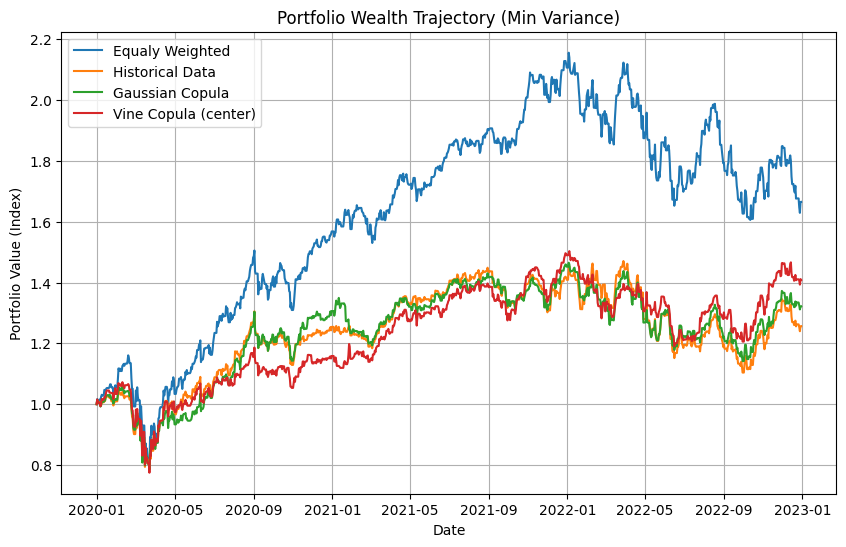

,Equaly Weighted,Historical Data,Gaussian Copula,Vine Copula (center)
Total Return,0.665220,0.256589,0.321705,0.408269
Mean Daily Return,0.000571,0.000291,0.000341,0.000393
Std Dev of Daily Return,0.014436,0.012812,0.013109,0.012660
Sharpe Ratio,0.039545,0.022725,0.026020,0.031071
Max Drawdown,-0.306158,-0.249379,-0.259668,-0.277693
Calmar Ratio,2.172796,1.028912,1.238905,1.470215
Alpha,0.000315,0.000082,0.000126,0.000193
Beta,1.034484,0.845689,0.872226,0.810705


In [17]:
from src.algorithms.strategy import MeanVariance

# Mean Variance strategy
meanVarOpt = MeanVariance()
meanVarOpt_bt = BackTest(main_data, meanVarOpt)

# with past data
past_gen = PastGen(use_log_returns=False)
meanVarOpt_bt.backtest(start_date, end_date, 12,1, '1MS', past_gen)
portfolio_returns["Historical Data"] = meanVarOpt_bt.portfolio_value
mean_semi_summary = meanVarOpt_bt.get_summary()
results["Historical Data"] = pd.Series(mean_semi_summary)

# with generated data from copula
gaussian_copula_gen = CopulaGen(copula_type='gaussian', sample_size = 100, use_log_returns=False)
meanVarOpt_bt.backtest(start_date, end_date, 12,1, '1MS', gaussian_copula_gen)
portfolio_returns["Gaussian Copula"] = meanVarOpt_bt.portfolio_value
mean_semi_summary = meanVarOpt_bt.get_summary()
results["Gaussian Copula"] = pd.Series(mean_semi_summary)

# with generated data from copula
vine_copula_gen = CopulaGen(copula_type='vine-center', sample_size = 100, use_log_returns=False)
meanVarOpt_bt.backtest(start_date, end_date, 12,1, '1MS', vine_copula_gen)
portfolio_returns["Vine Copula (center)"] = meanVarOpt_bt.portfolio_value
mean_semi_summary = meanVarOpt_bt.get_summary()
results["Vine Copula (center)"] = pd.Series(mean_semi_summary)

plt.figure(figsize=(10, 6))
for label, values in portfolio_returns.items():
    plt.plot(values, label=label)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Index)')
plt.title('Portfolio Wealth Trajectory (Min Variance)')
plt.legend()
plt.grid()
plt.show()

display(results)